<a href="https://colab.research.google.com/github/mathfish/LearningTopics/blob/main/Books/PytorchMastery/ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import requests
from pathlib import Path
import pandas as pd
import random

from timeit import default_timer
from tqdm.auto import tqdm

In [2]:
if Path("helpter_functions.py").is_file():
  print("Helper file exists")
else:
  print("Downloading helper functions . . . ")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [3]:
# Can also import accuracy function from torchmetrics (will need to pip install in Colab)

from helper_functions import accuracy_fn

In [89]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [95]:
from torchmetrics import ConfusionMatrix

In [93]:
print(torch.__version__)
print(mlxtend.__version__)

2.2.1+cu121
0.22.0


# Get and Explore Data Set

In [5]:
'''Get a Dataset

Going to use the MNIST fashion dataset from torchvision.datasets
60k train and 10k test


'''

train_data = datasets.FashionMNIST(root="data", # where to download to
                                   train=True,  # we want the training data
                                   download=True,
                                   transform=transforms.ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root="data", # where to download to
                                   train=False,  # we want the test data
                                   download=True,
                                   transform=transforms.ToTensor(),
                                   target_transform=None)

100%|██████████| 26421880/26421880 [00:01<00:00, 17099674.01it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 275162.72it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5055135.27it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15726348.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [6]:
image, label = train_data[0]

# C x H x W -> default for Pytorch but other libraries may want color channel last
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [7]:
class_name, class_to_index = train_data.classes, train_data.class_to_idx
class_name[label]

'Ankle boot'

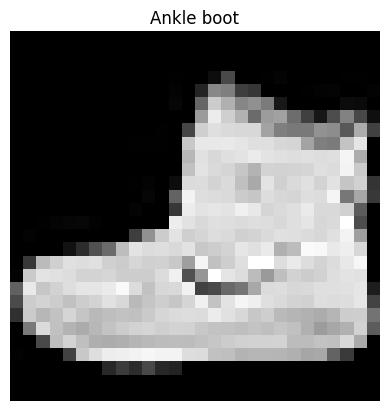

In [8]:
# Need to squeeze out the color. Matplotlib expects color channel last but easier to remove
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_name[label])
plt.axis(False);

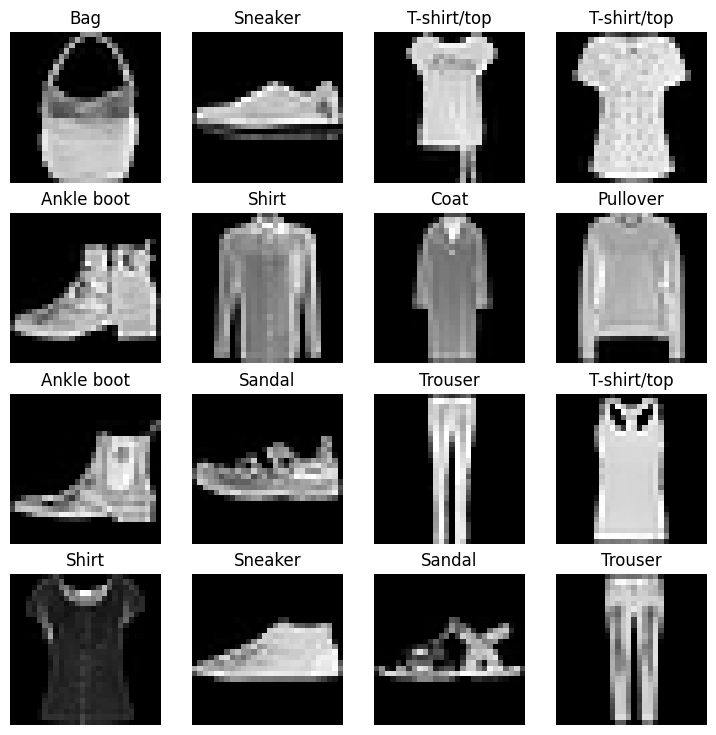

In [9]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  rand_indx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[rand_indx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_name[label])
  plt.axis(False)

# DataLoader - Prepare Data for Modeling

* DataLoader turns out dataset into a Python iterable
* Want to turn our data into mini-batches

**Why Mini Batches?**
* Typically cannot store total dataset in memory
* Mini Batches are more computationally efficient
* It gives our neural network more chances to update its gradients per epoch
* Called Mini Batch Gradient Descent

In [10]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True) # Shuffeling best for training
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)  # Easier to evaluate when not shuffled

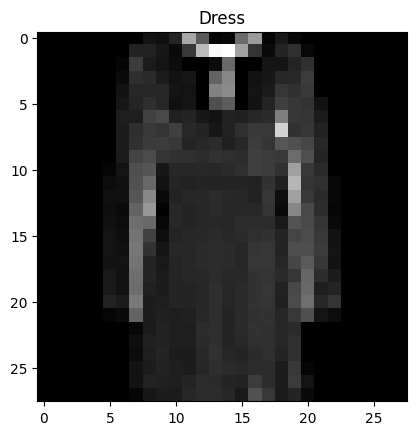

In [12]:
# show a sample
train_features_batch, train_labels_batch = next(iter(train_dataloader))

torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_name[label]);

# Build Baseline Model

Best to start with a baseline to improve upon

In [13]:
# Creata a flatten layer
flatten_model = nn.Flatten() # all layers can be used a model on their own

# Let's see what it does
x = train_features_batch[0] # [color_channel, height, width]
output = flatten_model(x)   # [color_channel, height * width]

print(f"Shape before flatten: {x.shape}")
print(f"Shape after flatten: {output.shape}")

Shape before flatten: torch.Size([1, 28, 28])
Shape after flatten: torch.Size([1, 784])


In [14]:
# non-linear module (no activation function) with linear feedforward layers

class FashionMNIST_v0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),  # Need to flatten to get proper shape for input to linear layer
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [15]:
torch.manual_seed(42)

# setup model with input parameters
model_v0 = FashionMNIST_v0(input_shape=784,
                           hidden_units=10,
                           output_shape=len(class_name)
                           ).to("cpu")


dummy_x = torch.rand([1, 1, 28, 28])
model_v0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [16]:
# need loss function, optimizer, and evaluation metrics

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)

In [17]:
# Let's create a helper function to time our model

def print_train_time(start: float, end: float, device: torch.device = None):
  '''Prints difference between start and end time'''

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")

  return total_time

# Set up Training

Will
1. Loop through epochs
2. Loop through mini batches, perform training steps, calculate train loss per batch
3. Loop through testing batches, perform testing steps, and calculate test loss per batch

In [18]:
torch.manual_seed(42)
train_time_start_cpu = default_timer()

# will keep it small for faster training iterations
epochs = 3

# create training and test loop

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----------")

  ### Train
  train_loss = 0

  # loop through batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_v0.train()

    # forward pass
    y_pred = model_v0(X)

    # calc loss
    loss = loss_fn(y_pred, y) # logits are the predictions
    train_loss += loss # accumulate losses over batches

    # zero grad optimizer
    optimizer.zero_grad()

    # back prop
    loss.backward()

    # step optimizer
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")


  # divide total train loss by length of train dataloader (ie. num batches) to get loss per batch
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_v0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_v0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test,
                              y_pred=torch.softmax(test_pred, dim=1).argmax(dim=1))

    # compute metrics per test batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

train_time_end_on_cpu = default_timer()

total_train_time_model_v0 = print_train_time(train_time_start_cpu, train_time_end_on_cpu, str(next(model_v0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 33.984 seconds


# Make Predictions with Baseline Model

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn, device: torch.device = device):
  """Returns dict containing results of model predictions"""

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      # make predictions
      y_pred = model(X)

      # accum loss and acc per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # will just use argmax and not softmax as above. Same thing

      # scale loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc
          }

In [20]:
model_v0_results = eval_model(model_v0, test_dataloader, loss_fn, accuracy_fn, "cpu")

  0%|          | 0/313 [00:00<?, ?it/s]

In [21]:
model_v0_results

{'model_name': 'FashionMNIST_v0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

# Device Agnostic

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class FashionMNIST_v1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),  # Need to flatten to get proper shape for input to linear layer
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [24]:
torch.manual_seed(42)
model_v1 = FashionMNIST_v1(input_shape=784, hidden_units=10, output_shape=len(class_name)).to(device)

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v1.parameters(), lr=0.1)

In [26]:
### create training and testing methods

def training_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
                  accuracy_fn, device: torch.device = device
                  ):

  train_loss, train_acc = 0, 0
  model.train()

  # loop through batches
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calc loss and loss
    loss = loss_fn(y_pred, y) # logits are the predictions
    acc = accuracy_fn(y,
                      y_pred=torch.softmax(y_pred, dim=1).argmax(dim=1))

    train_loss += loss # accumulate losses over batches
    train_acc += acc

    # zero grad optimizer
    optimizer.zero_grad()

    # back prop
    loss.backward()

    # step optimizer
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)} / {len(data_loader.dataset)} samples")


  # divide total train loss by length of train dataloader (ie. num batches) to get loss per batch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")


def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test,
                              y_pred=torch.softmax(test_pred, dim=1).argmax(dim=1))

    # compute metrics per test batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%\n")

In [27]:
torch.manual_seed(42)
train_time_start_gpu = default_timer()

# will keep it small for faster training iterations
epochs = 3

# create training and test loop

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----------")

  training_step(model_v1, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_v1, train_dataloader, loss_fn, accuracy_fn, device)

train_time_end_on_gpu = default_timer()
total_train_time_model_v1 = print_train_time(train_time_start_gpu, train_time_end_on_gpu, str(next(model_v1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 1.0920 | Train acc: 61.34%

Test loss: 0.9273 | Test acc: 66.00%

Epoch: 1
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.7378 | Train acc: 73.69%

Test loss: 0.6879 | Test acc: 75.43%

Epoch: 2
-----------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.6678 | Train acc: 76.08%

Test loss: 0.6433 | Test acc: 76.87%

Train time on cpu: 53.913 seconds


In [28]:
model_v1_results = eval_model(model_v1, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

# CNN Model

Will replicate TinyVGG model

In [29]:
class FashionMNIST_v2(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3, # equivalent / short for (3,3)
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    return self.classifier(x)


In [30]:
torch.manual_seed(42)

# We have only 1 color channel since black and white images
model_v2 = FashionMNIST_v2(input_shape=1, hidden_units=10, output_shape=len(class_name)).to(device)

## Explore Conv2D and MaxPool2d

In [31]:
torch.manual_seed(42)

# create dummy batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

# create single conv2d layer

conv_layer = nn.Conv2d(in_channels=3,
          out_channels=10,
          kernel_size=(3,3),
          stride=1, padding=0)

# pass data through
conv_output = conv_layer(test_image)
conv_output.shape


torch.Size([10, 62, 62])

In [32]:
max_pool_2d = nn.MaxPool2d(kernel_size=3)
max_output = max_pool_2d(conv_output)
max_output.shape

torch.Size([10, 20, 20])

## Train the CNN

In [33]:
start_time_cnn = default_timer()

loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v2.parameters(), lr=0.1)

epochs = 3

torch.manual_seed(42)

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------------------")
  training_step(model_v2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(model_v2, test_dataloader, loss_fn, accuracy_fn, device)

stop_time_cnn = default_timer()
total_train_time_model_v2 = print_train_time(start_time_cnn, stop_time_cnn, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------------------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.5952 | Train acc: 78.38%

Test loss: 0.3950 | Test acc: 85.99%

Epoch: 1
--------------------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.3654 | Train acc: 86.90%

Test loss: 0.3524 | Test acc: 86.91%

Epoch: 2
--------------------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples

Train loss: 0.3259 | Train acc: 88.13%

Test loss: 0.3272 | Test acc: 88.07%

Train time on cpu: 174.589 seconds


In [34]:
model_2_results = eval_model(model_v2, test_dataloader, loss_fn, accuracy_fn, device)

  0%|          | 0/313 [00:00<?, ?it/s]

In [35]:
model_2_results

{'model_name': 'FashionMNIST_v2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

# Compare Results

In [36]:
compare_results = pd.DataFrame([model_v0_results, model_v1_results, model_2_results])
compare_results["training_time"] = [total_train_time_model_v0, total_train_time_model_v1, total_train_time_model_v2]

In [37]:
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNIST_v0,0.476639,83.426518,33.984000
1,FashionMNIST_v1,0.687435,75.658946,53.913387
2,FashionMNIST_v2,0.327190,88.069089,174.589424


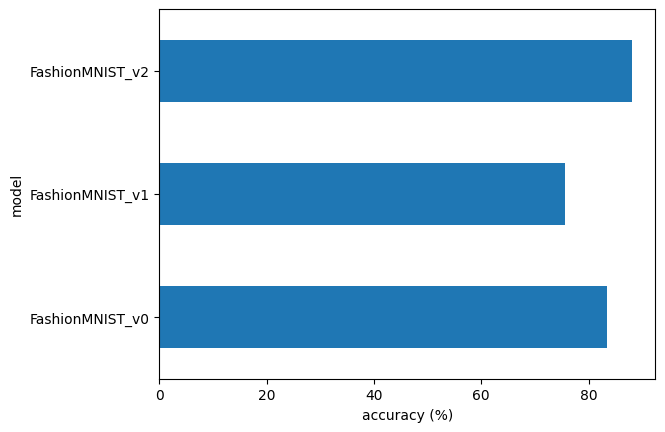

In [38]:
compare_results.set_index("model_name")['model_acc'].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# Make Predictions on Random Samples

In [70]:
def make_predictions(model: nn.Module, data: list, device: torch.device=device):
  pred_probs = []
  model.to(device)

  model.eval()
  with torch.inference_mode():
    for sample in data:

      # add batch dimension
      sample = sample.unsqueeze(0).to(device)

      pred_logit = model(sample)

      # logit -> pred prob, remove extra dim
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # move data to cpu
      pred_probs.append(pred_prob.cpu())

  # concatenate list to single tensor
  return torch.stack(pred_probs)


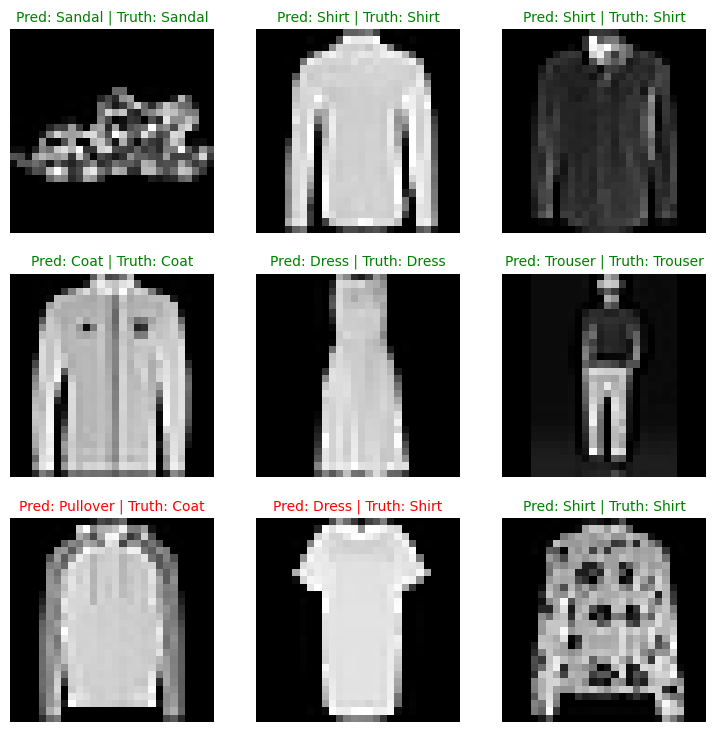

In [88]:
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model_v2, test_samples)
pred_labels = pred_probs.argmax(dim=1)

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")

  truth_label = class_name[test_labels[i]]
  pred_label = class_name[pred_labels[i]]

  title_txt = f"Pred: {pred_label} | Truth: {truth_label}"
  c = "g" if pred_label == truth_label else "r"

  plt.title(title_txt, fontsize=10, c=c)
  plt.axis(False)


# Confusion Matrix

Will use torchmetrics and mlxtend



In [91]:
y_preds = []

model_v2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions...."):
    X, y = X.to(device), y.to(device)

    y_logit = model_v2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making Predictions....:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

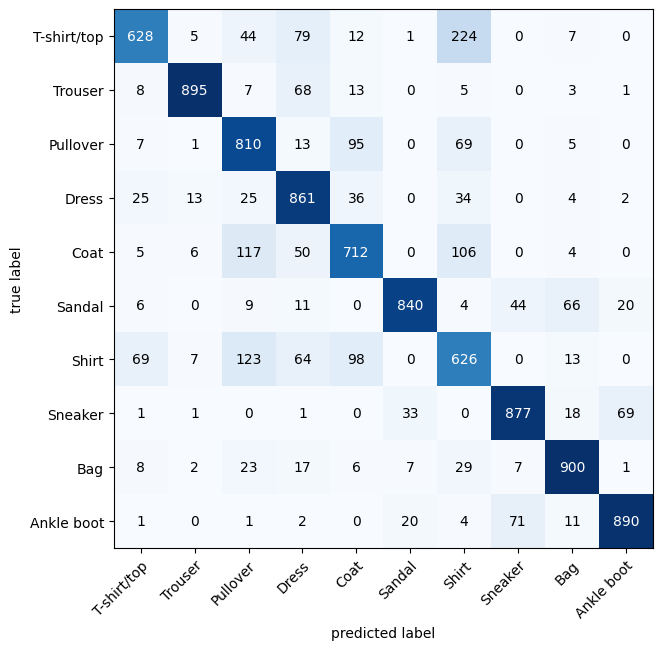

In [104]:
cmatrix = ConfusionMatrix(task="multiclass", num_classes = len(class_name))

cmatrix_tensor = cmatrix(y_pred_tensor, target=test_data.targets)


fig, ax = plot_confusion_matrix(cmatrix_tensor.numpy(),
                      class_names=class_name,
                      figsize=(10, 7),

                      )

# Save And Export Model

In [106]:
# create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "cnn_model_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model
torch.save(obj=model_v2.state_dict(), f=MODEL_SAVE_PATH)

In [108]:
# create new instance
torch.manual_seed(42)

loaded_model_v2 = FashionMNIST_v2(input_shape=1,
                                  hidden_units=10,
                                  output_shape=len(class_name))

# load state dict
loaded_model_v2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_v2.to(device)

FashionMNIST_v2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [109]:
# check similar performance
torch.manual_seed(42)


loaded_model_v2_results = eval_model(loaded_model_v2, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [110]:
loaded_model_v2_results

{'model_name': 'FashionMNIST_v2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

In [111]:
model_2_results

{'model_name': 'FashionMNIST_v2',
 'model_loss': 0.32718968391418457,
 'model_acc': 88.06908945686901}

In [112]:
torch.isclose(torch.tensor(loaded_model_v2_results["model_loss"]),
              torch.tensor(model_2_results["model_loss"]))

tensor(True)